In [ ]:
!pip install gym~=0.17.3
!pip install numpy==1.19.4
!pip install boolean.py@git+https://github.com/bastikr/boolean.py/@74063a8588875c058e6dbbb85b69ed052e1f2099#egg=boolpy_stubs
!pip install networkx==2.4
!pip install pyyaml~=5.4.1
!pip install setuptools~=49.2.1
!pip install matplotlib~=3.2.1
!pip install plotly~=4.11.0
!pip install tabulate~=0.8.7
!pip install ordered_set==4.0.2
!pip install progressbar2==3.51.4
!pip install decorator==4.3

In [1]:
import sys
import math
import random
import progressbar
import numpy as np
from time import time
from copy import deepcopy
from typing import TypedDict
from itertools import combinations

import cyberbattle._env.cyberbattle_env
import cyberbattle.agents.baseline.agent_wrapper as w
from cyberbattle.simulation import actions, model
from cyberbattle._env.defender import ScanAndReimageCompromisedMachines
from cyberbattle._env.cyberbattle_env import AttackerGoal, Action, DefenderConstraint

import gym
from gym.utils import seeding

# gym_env = gym.make('CyberBattleToyCtf-v0', attacker_goal=AttackerGoal(own_atleast=6))

gym_env = gym.make('CyberBattleToyCtf-v0', attacker_goal=AttackerGoal(own_atleast_percent=0.6, low_availability=0.4))

import logging
# logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s")

In [2]:
def action_to_string(action):
    key, value = list(action.items())[0][0], list(action.items())[0][1]
    action_str = f"{key}-{list(value)}"
    return action_str

def string_to_action(action_str):
    key, value_str = action_str.split('-')
    if key == 'connect':
        _val = eval(value_str)
        value = np.array(_val, np.int32)
        return Action(connect=value)
    elif key == 'local_vulnerability':
        _val = eval(value_str)
        value = np.array(_val, np.int32)
        return Action(local_vulnerability=value)
    else:
        _val = eval(value_str)
        value = np.array(_val, np.int32)
        return Action(remote_vulnerability=value)
    
def convert_to_action(env, action):
    for k in action.keys():
        if k == 'connect':
            atk_detail_node = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][0])
            atk_detail_target = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][1])
            atk_detail_port = env._CyberBattleEnv__index_to_port_name(list(action.values())[0][2])
            atk_detail_cred = env._CyberBattleEnv__credential_cache[list(action.values())[0][3]]
            return f'Attack Type: {k}\nFrom Node: {atk_detail_node}\nTarget Node: {atk_detail_target}\nOn Port: {atk_detail_port}\nCredentials: {atk_detail_cred}\n'
        elif k == 'local_vulnerability':
            atk_detail_node = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][0])
            atk_detail_atk = env._CyberBattleEnv__index_to_local_vulnerabilityid(list(action.values())[0][1])
            return f'Attack Type: {k}\nFrom Node: {atk_detail_node}\nAttack Type: {atk_detail_atk}\n'
        else:
            atk_detail_node = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][0])
            atk_detail_target = env._CyberBattleEnv__internal_node_id_from_external_node_index(list(action.values())[0][1])
            atk_detail_atk = env._CyberBattleEnv__index_to_remote_vulnerabilityid(list(action.values())[0][2])
            return f'Attack Type: {k}\nFrom Node: {atk_detail_node}\nTarget Node: {atk_detail_target}\nAttack Type: {atk_detail_atk}\n'

In [3]:
def randomPolicy(state, random, bar):
    '''
    Policy followed in MCTS simulation for playout
    '''
    reward = 0.
    action_list = list(state.getActions())
    while not state.isDone():
        action = random.choice(action_list)
        state = state.simulateStep(action=action)
        reward += state.getReward()
        action_list = list(state.getActions())
        bar.update(bar.value+1)
    return reward

In [4]:
class NetworkState():
    def __init__(self, state, env=None, taken_before=set(), done=False, reward=0):
        '''
        Data structure to represent state of the environment
        self.env : Environment of gym_network_environment simulator
        self.state : State of the gym_network_environment
        self.is_done : Denotes whether the NetworkState is terminal
        self.num_lanes : Number of nodes in gym_network_environment
        self.width : Width of lanes in gym_network_environment
        self.reward : Reward of the state
        '''
        self.state = state
        self.env = deepcopy(env)
        self.is_done = done
        self.reward = reward
        
        self.actions_taken_before = taken_before
        
    def simulateStep(self, action):
        '''
        Simulates action at self.state and returns the next state
        '''
        env = deepcopy(self.env)
        observation, reward, done, info = env.step(action=action)
        _actions_before = deepcopy(self.actions_taken_before)
        _actions_before.add(action_to_string(action))
        newState = NetworkState(observation, env=env, taken_before=_actions_before, done=done, reward=reward)
        return newState

    def isDone(self):
        '''
        Returns whether the state is terminal
        '''
        return self.is_done

    def getReward(self):
        '''
        Returns reward of the state
        '''
        return self.reward
    
    def getActions(self):
        _actions = []
        
        # AgentActions
        env_actions = actions.AgentActions(self.env._CyberBattleEnv__environment)
        
        # Get Source Node
        potential_source_nodes = w.owned_nodes(self.state)
        client_node = potential_source_nodes[0]
        source_node_names = {self.env._CyberBattleEnv__internal_node_id_from_external_node_index(node):node for node in potential_source_nodes}
        
        # Get Target Node
        nodes_not_owned = w.discovered_nodes_notowned(self.state)
        target_node_names = {node:i for i, node in enumerate(self.env._CyberBattleEnv__discovered_nodes)}
        
        
        # Connect
        discovered_credentials = np.array(self.state['credential_cache_matrix'])
        n_discovered_creds = len(discovered_credentials)
        if n_discovered_creds > 0:
            match_port__target_notowned = [c for c in range(n_discovered_creds)
                                           if discovered_credentials[c, 0] in nodes_not_owned]
            
            if match_port__target_notowned:
                cred = np.int32(np.random.choice(match_port__target_notowned))
                target = np.int32(discovered_credentials[cred, 0])
                port = np.int32(discovered_credentials[cred, 1])
                for source_node in potential_source_nodes:
                    _actions.append(Action(connect=np.array([client_node, target, port, cred], dtype=np.int32)))
                ## For other ports
                for source_node in potential_source_nodes:
                    for port in range(self.env._CyberBattleEnv__bounds.port_count):
                        _actions.append(Action(connect=np.array([source_node, target, port, cred], dtype=np.int32)))

        
        # Remote Vulnerability
        num_of_remote_vuls = self.env._CyberBattleEnv__bounds.remote_attacks_count
        all_remote_vul = {self.env._CyberBattleEnv__index_to_remote_vulnerabilityid(atk_id):atk_id for atk_id in range(num_of_remote_vuls)}

        for node_name, t_node in target_node_names.items():
            for atk in env_actions.list_vulnerabilities_in_target(node_name, model.VulnerabilityType.REMOTE):
                remote_atk = all_remote_vul[atk]
                _actions.append(Action(remote_vulnerability=np.array([client_node, t_node, remote_atk], dtype=np.int32)))
        
        
        # Local Vulnerability
        num_of_local_vuls = self.env._CyberBattleEnv__bounds.local_attacks_count
        all_local_vul = {self.env._CyberBattleEnv__index_to_local_vulnerabilityid(atk_id):atk_id for atk_id in range(num_of_local_vuls)}
        
        for node_name, s_node in source_node_names.items():
            for atk in env_actions.list_vulnerabilities_in_target(node_name, model.VulnerabilityType.LOCAL):
                local_atk = all_local_vul[atk]
                _actions.append(Action(local_vulnerability=np.array([s_node, local_atk], dtype=np.int32)))
        
        
        # Get unique and untaken actions
        uniq_actions = []
        for action in _actions:
            if self.env.is_action_valid(action, self.state['action_mask']):
                action_str = action_to_string(action)
                if action_str not in self.actions_taken_before and action_str not in uniq_actions:
                    uniq_actions.append(action_str)
        uniq_actions = [string_to_action(action_str) for action_str in uniq_actions]
        
        return uniq_actions

In [5]:
class Node:
    def __init__(self, state, parent=None):
        '''
        Data structure for a node of the MCTS tree
        self.state : GridWorld state represented by the node
        self.parent : Parent of the node in the MCTS tree
        self.numVisits : Number of times the node has been visited
        self.totalReward : Sum of all rewards backpropagated to the node
        self.isDone : Denotes whether the node represents a terminal state
        self.allChildrenAdded : Denotes whether all actions from the node have been explored
        self.children : Set of children of the node in the MCTS tree
        '''
        self.state = state
        self.parent = parent
        self.numVisits = 0
        self.totalReward = state.reward #0
        self.isDone = state.isDone()
        self.allChildrenAdded = state.isDone()
        self.children = {}

In [6]:
class MonteCarloTreeSearch(object):
    def __init__(self, numiters, explorationParam, playoutPolicy=randomPolicy, env=None, random_seed=None):
        '''
        self.numiters : Number of MCTS iterations
        self.explorationParam : exploration constant used in computing value of node
        self.playoutPolicy : Policy followed by agent to simulate rollout from leaf node
        self.root : root node of MCTS tree
        '''
        self.env = env
        self.numiters = numiters
        self.explorationParam = explorationParam
        self.playoutPolicy = playoutPolicy
        self.root = None
        self.random, self.seed = seeding.np_random(random_seed)
        
        self._steps_taken = None

    def buildTreeAndReturnBestAction(self, initialState, bar):
        '''
        Function to build MCTS tree and return best action at initialState
        '''
        self.root = Node(state=initialState, parent=None)
        self._steps_taken = 0
        for i in range(self.numiters):
            self.addNodeAndBackpropagate(bar)
        bestChild = self.chooseBestActionNode(self.root, 0)
        for action_str, cur_node in self.root.children.items():
            if cur_node is bestChild:
                action = string_to_action(action_str)
                return action, self._steps_taken/self.numiters

    def addNodeAndBackpropagate(self, bar):
        '''
        Function to run a single MCTS iteration
        '''
        node = self.addNode(bar)
        _tmp = bar.value-1
        reward = self.playoutPolicy(node.state, self.random, bar)
        self._steps_taken += bar.value-_tmp
        self.backpropagate(node, reward)

    def addNode(self, bar):
        '''
        Function to add a node to the MCTS tree
        '''
        cur_node = self.root
        bar.update(bar.value+1)
        while not cur_node.isDone:
            if cur_node.allChildrenAdded:
                cur_node = self.chooseBestActionNode(cur_node, self.explorationParam)
            else:
                actions_list = cur_node.state.getActions()
                for action in actions_list:
                    
                    # Convert action to action string
                    action_str = action_to_string(action)
                    
                    # Check if invalid actions or already a tried action
                    if action_str not in cur_node.children:
                        childnode = cur_node.state.simulateStep(action=action)
                        newNode = Node(state=childnode, parent=cur_node)
                        cur_node.children[action_str] = newNode
                        if len(actions_list) == len(cur_node.children):
                            cur_node.allChildrenAdded = True
                        return newNode
    
        return cur_node

    def backpropagate(self, node, reward):
        '''
        FILL ME : This function should implement the backpropation step of MCTS.
                  Update the values of relevant variables in Node Class to complete this function
        '''
        while True:
            # Add values to node
            node.totalReward += reward
            node.numVisits += 1

            # Terminating Condition
            if node.parent is None:
                break

            # Go to parent node
            node = node.parent

    def chooseBestActionNode(self, node, explorationValue):
        random = self.random
        bestValue = float("-inf")
        bestNodes = []
        for child in node.children.values():
            '''
            FILL ME : Populate the list bestNodes with all children having maximum value

                       Value of all nodes should be computed as mentioned in question 3(b).
                       All the nodes that have the largest value should be included in the list bestNodes.
                       We will then choose one of the nodes in this list at random as the best action node.
            '''
            # Get Child values
            try:
                child_value = (child.totalReward/child.numVisits) + \
                    explorationValue * math.sqrt((math.log(node.numVisits) / child.numVisits))
            except ZeroDivisionError:  # Case if division by zero
                child_value = 0

            # Case if child value more than best value
            if child_value > bestValue:
                bestNodes = [child,]
                bestValue = child_value
            elif child_value == bestValue:  # Case if child value is best value
                bestNodes.append(child)

        return random.choice(bestNodes)

In [7]:
### Execute runs ###

## Random seeding ##
RANDOM_SEED = 10

reward_records = []
time_records = []
action_records = []

for iter_i in range(1,10):
    
    ## Progressbar widgets ##
    _widgets = ['Episode ', f'{iter_i}',
                '|Iteration ', progressbar.Counter(),
                '|', progressbar.Variable(name='reward', width=6, precision=10),
                '|', progressbar.Variable(name='last_reward_at', width=4),
                '|', progressbar.Variable(name='last_reward_value', width=3),
                '|', progressbar.Timer(),
                progressbar.Bar()]
    
    bar = progressbar.ProgressBar(
            widgets=_widgets,
            redirect_stdout=True,
            max_value=progressbar.UnknownLength)
    
    ## Environment parameters to reset ##
    done = False
    state = gym_env.reset()
    mcts = MonteCarloTreeSearch(env=deepcopy(gym_env), numiters=iter_i, explorationParam=1., random_seed=RANDOM_SEED)
    
    reward_record = []
    time_record = []
    action_record = []
    taken_actions = set()
    
    while True:  
        net_state = NetworkState(state, env=gym_env, taken_before=taken_actions, done=done)

        start_time = time()
        action, pad_rewards = mcts.buildTreeAndReturnBestAction(initialState=net_state, bar=bar)
        time_elapsed = time() - start_time
        time_record.append(time_elapsed)

        printable_action = convert_to_action(gym_env, action)
        action_record.append(printable_action)
        taken_actions.add(action_to_string(action))
        
        state, reward, done, info = gym_env.step(action)
        
        for _ in range(int(pad_rewards)):
            reward_record.append(0.0)
        reward_record.append(reward)
        
        bar.update(bar.value+1)
        bar.update(bar.value, reward=sum(reward_record))
        
        if reward>0:
            bar.update(bar.value, last_reward_at=bar.value, last_reward_value=reward)

        if done == True:
            bar.finish(dirty=True)
            break

    sys.stdout.flush()
    reward_records.append(reward_record)
    time_records.append(time_record)
    action_records.append(action_record)
    
print ("simulation done")

Episode 1|Iteration 982|reward: 5381.0|last_reward_at:  982|last_reward_value: 5e+03|Elapsed Time: 0:00:08|#|
Episode 2|Iteration 1698|reward: 5381.0|last_reward_at: 1698|last_reward_value: 5e+03|Elapsed Time: 0:00:14|#|
Episode 3|Iteration 2824|reward: 5375.0|last_reward_at: 2824|last_reward_value: 5e+03|Elapsed Time: 0:00:23|#|
Episode 4|Iteration 4954|reward: 5381.0|last_reward_at: 4954|last_reward_value: 5e+03|Elapsed Time: 0:00:42|#|
Episode 5|Iteration 4538|reward: 5381.0|last_reward_at: 4538|last_reward_value: 5e+03|Elapsed Time: 0:00:41|#|
Episode 6|Iteration 5389|reward: 5375.0|last_reward_at: 5389|last_reward_value: 5e+03|Elapsed Time: 0:00:50|#|
Episode 7|Iteration 8674|reward: 5381.0|last_reward_at: 8674|last_reward_value: 5e+03|Elapsed Time: 0:01:19|#|
Episode 8|Iteration 6713|reward: 5381.0|last_reward_at: 6713|last_reward_value: 5e+03|Elapsed Time: 0:00:59|#|
Episode 9|Iteration 10452|reward: 5381.0|last_reward_at: 10452|last_reward_value: 5e+03|Elapsed Time: 0:01:37|#|


simulation done


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def new_plot(title):
    """Prepare a new plot of cumulative rewards"""
    plt.figure(figsize=(10, 8))
    plt.ylabel('cumulative reward', fontsize=20)
    plt.xlabel('step', fontsize=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title(title, fontsize=12)


def pad(array, length):
    """Pad an array with 0s to make it of desired length"""
    padding = np.zeros((length,))
    padding[:len(array)] = array
    return padding

def plot_episodes_rewards_averaged(results, title):
    """Plot cumulative rewards for a given set of specified episodes"""
    max_iteration_count = np.max([len(r) for r in results])

    all_episodes_rewards_padded = [pad(rewards, max_iteration_count) for rewards in results]
    cumrewards = np.cumsum(all_episodes_rewards_padded, axis=1)
    avg = np.average(cumrewards, axis=0)
    std = np.std(cumrewards, axis=0)
    x = [i for i in range(len(std))]
    plt.plot(x, avg, label=title)
    plt.fill_between(x, avg - std, avg + std, alpha=0.5)
    
def plot_episodes_rewards_averaged_ori(results):
    """Plot cumulative rewards for a given set of specified episodes"""
    max_iteration_count = np.max([len(r) for r in results['all_episodes_rewards']])

    all_episodes_rewards_padded = [pad(rewards, max_iteration_count) for rewards in results['all_episodes_rewards']]
    cumrewards = np.cumsum(all_episodes_rewards_padded, axis=1)
    avg = np.average(cumrewards, axis=0)
    std = np.std(cumrewards, axis=0)
    x = [i for i in range(len(std))]
    plt.plot(x, avg, label=results['title'])
    plt.fill_between(x, avg - std, avg + std, alpha=0.5)
    
def plot_episodes_length(learning_results, title):
    """Plot length of every episode"""
    plt.figure(figsize=(10, 8))
    plt.ylabel('#iterations', fontsize=20)
    plt.xlabel('episode', fontsize=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("Length of each episode", fontsize=12)

    for results in learning_results:
        iterations = [len(e) for e in results['all_episodes_rewards']]
        episode = [i for i in range(len(results['all_episodes_rewards']))]
        plt.plot(episode, iterations, label=results['title'])

    plt.legend(loc="upper right")
    plt.show()
    
def plot_each_episode(results):
    """Plot cumulative rewards for each episode"""
    for i, episode in enumerate(results['all_episodes_rewards']):
        cumrewards = np.cumsum(episode)
        x = [i for i in range(len(cumrewards))]
        plt.plot(x, cumrewards, label=f'Episode {i}')


def plot_all_episodes(r):
    """Plot cumulative rewards for every episode"""
    new_plot(r['title'])
    plot_each_episode(r)
    plt.legend(loc="lower right")
    plt.show()

In [9]:
trimmed_rewards = list(map(lambda x: x[:-1]+[50,], reward_records))

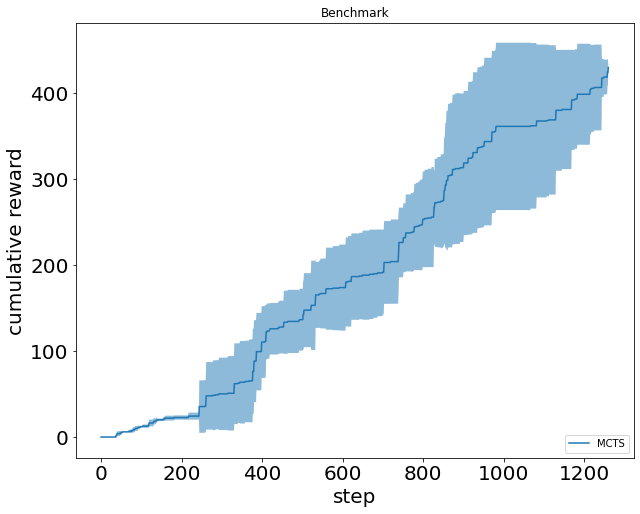

In [10]:
new_plot('Benchmark')
plot_episodes_rewards_averaged(trimmed_rewards, 'MCTS')
plt.legend(loc="lower right")
plt.show()

In [ ]:
gym_env.render()

In [11]:
import sys
import logging
import gym
import cyberbattle.agents.baseline.learner as learner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_tabularqlearning as tqa
import cyberbattle.agents.baseline.agent_dql as dqla
from cyberbattle.agents.baseline.agent_wrapper import Verbosity

logging.basicConfig(stream=sys.stdout, level=logging.ERROR, format="%(levelname)s: %(message)s")

In [12]:
# Parameters
gymid = "CyberBattleToyCtf-v0"
iteration_count = 1500
training_episode_count = 20
eval_episode_count = 10
maximum_node_count = 12
maximum_total_credentials = 10


In [13]:
# Load the Gym environment
# if env_size:
#     gym_env = gym.make(gymid, size=env_size)
# else:
#     gym_env = gym.make(gymid)

ep = w.EnvironmentBounds.of_identifiers(
    maximum_node_count=maximum_node_count,
    maximum_total_credentials=maximum_total_credentials,
    identifiers=gym_env.identifiers
)

In [14]:
debugging = False
if debugging:
    print(f"port_count = {ep.port_count}, property_count = {ep.property_count}")

    gym_env.environment
    # training_env.environment.plot_environment_graph()
    gym_env.environment.network.nodes
    gym_env.action_space
    gym_env.action_space.sample()
    gym_env.observation_space.sample()
    o0 = gym_env.reset()
    o_test, r, d, i = gym_env.step(gym_env.sample_valid_action())
    o0 = gym_env.reset()

    o0.keys()

    fe_example = w.RavelEncoding(ep, [w.Feature_active_node_properties(ep), w.Feature_discovered_node_count(ep)])
    a = w.StateAugmentation(o0)
    w.Feature_discovered_ports(ep).get(a, None)
    fe_example.encode_at(a, 0)

###### Credential lookups (ϵ-greedy)
Learning with: episode_count=10,iteration_count=1500,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=10000,
  ## Episode: 1/10 'Credential lookups (ϵ-greedy)' ϵ=0.9000, 


Episode 1|Iteration 1500|reward:  163.0|last_reward_at:  589|Elapsed Time: 0:00:01||


  Episode 1 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/156 (0.01)
    explore-remote: 8/1103 (0.01)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/230 (0.01)
  exploit deflected to exploration: 21
  ## Episode: 2/10 'Credential lookups (ϵ-greedy)' ϵ=0.7886, 


Episode 2|Iteration 1500|reward:  163.0|last_reward_at:  339|Elapsed Time: 0:00:01||


  Episode 2 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/109 (0.01)
    explore-remote: 8/1014 (0.01)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/366 (0.01)
  exploit deflected to exploration: 2
  ## Episode: 3/10 'Credential lookups (ϵ-greedy)' ϵ=0.6927, 


Episode 3|Iteration 1500|reward:  163.0|last_reward_at:  315|Elapsed Time: 0:00:01||


  Episode 3 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/110 (0.01)
    explore-remote: 8/889 (0.01)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/490 (0.00)
  exploit deflected to exploration: 13
  ## Episode: 4/10 'Credential lookups (ϵ-greedy)' ϵ=0.6102, 


Episode 4|Iteration 1500|reward:  163.0|last_reward_at:  416|Elapsed Time: 0:00:01||


  Episode 4 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/86 (0.01)
    explore-remote: 8/784 (0.01)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/619 (0.00)
  exploit deflected to exploration: 17
  ## Episode: 5/10 'Credential lookups (ϵ-greedy)' ϵ=0.5391, 


Episode 5|Iteration 1500|reward:  163.0|last_reward_at:  608|Elapsed Time: 0:00:01||


  Episode 5 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/82 (0.01)
    explore-remote: 8/682 (0.01)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/725 (0.00)
  exploit deflected to exploration: 28
  ## Episode: 6/10 'Credential lookups (ϵ-greedy)' ϵ=0.4779, 


Episode 6|Iteration 1500|reward:  163.0|last_reward_at:  504|Elapsed Time: 0:00:01||


  Episode 6 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/75 (0.01)
    explore-remote: 8/638 (0.01)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/776 (0.00)
  exploit deflected to exploration: 13
  ## Episode: 7/10 'Credential lookups (ϵ-greedy)' ϵ=0.4253, 


Episode 7|Iteration 1500|reward:  163.0|last_reward_at:  164|Elapsed Time: 0:00:01||


  Episode 7 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/80 (0.01)
    explore-remote: 8/582 (0.01)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/827 (0.00)
  exploit deflected to exploration: 57
  ## Episode: 8/10 'Credential lookups (ϵ-greedy)' ϵ=0.3800, 


Episode 8|Iteration 1500|reward:  163.0|last_reward_at:  349|Elapsed Time: 0:00:01||


  Episode 8 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/59 (0.02)
    explore-remote: 8/472 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/958 (0.00)
  exploit deflected to exploration: 14
  ## Episode: 9/10 'Credential lookups (ϵ-greedy)' ϵ=0.3410, 


Episode 9|Iteration 1500|reward:  163.0|last_reward_at:  292|Elapsed Time: 0:00:01||


  Episode 9 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/56 (0.02)
    explore-remote: 8/453 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/980 (0.00)
  exploit deflected to exploration: 64
  ## Episode: 10/10 'Credential lookups (ϵ-greedy)' ϵ=0.3074, 


Episode 10|Iteration 1500|reward:  163.0|last_reward_at:  243|Elapsed Time: 0:00:01||


  Episode 10 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/53 (0.02)
    explore-remote: 8/510 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 2/926 (0.00)
  exploit deflected to exploration: 179
simulation ended


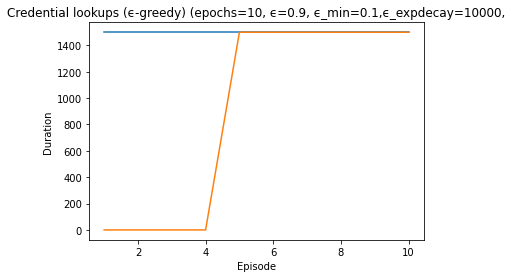

In [15]:
# Evaluate a random agent that opportunistically exploits
# credentials gathere in its local cache
credlookup_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=rca.CredentialCacheExploiter(),
    episode_count=10,
    iteration_count=iteration_count,
    epsilon=0.90,
    render=False,
    epsilon_exponential_decay=10000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    title="Credential lookups (ϵ-greedy)"
)

In [16]:
# Evaluate a Tabular Q-learning agent
tabularq_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=tqa.QTabularLearner(
        ep,
        gamma=0.015, learning_rate=0.01, exploit_percentile=100),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.01,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tabular Q-learning"
)

###### Tabular Q-learning
Learning with: episode_count=20,iteration_count=1500,ϵ=0.9,ϵ_min=0.01, ϵ_expdecay=5000,γ=0.015,learning_rate=0.01,Q%=100
  ## Episode: 1/20 'Tabular Q-learning' ϵ=0.9000, γ=0.015,learning_rate=0.01,Q%=100


Episode 1|Iteration 1500|reward:  272.0|last_reward_at:  879|Elapsed Time: 0:00:02||


  Episode 1 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/85 (0.02)
    explore-remote: 8/583 (0.01)
    explore-connect: 1/540 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/9 (0.00)
    exploit-connect: 2/270 (0.01)
  exploit deflected to exploration: 40
  ## Episode: 2/20 'Tabular Q-learning' ϵ=0.6695, γ=0.015,learning_rate=0.01,Q%=100


Episode 2|Iteration 1032|reward: 5381.0|last_reward_at: 1032|Elapsed Time: 0:00:02||


  Episode 2 ended at t=1032 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/73 (0.04)
    explore-remote: 7/306 (0.02)
    explore-connect: 2/270 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 1/5 (0.17)
    exploit-connect: 3/362 (0.01)
  exploit deflected to exploration: 48
  ## Episode: 3/20 'Tabular Q-learning' ϵ=0.5465, γ=0.015,learning_rate=0.01,Q%=100


Episode 3|Iteration 1500|reward:  272.0|last_reward_at:  954|Elapsed Time: 0:00:02||


  Episode 3 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/48 (0.02)
    explore-remote: 5/331 (0.01)
    explore-connect: 1/362 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/10 (0.23)
    exploit-connect: 2/736 (0.00)
  exploit deflected to exploration: 22
  ## Episode: 4/20 'Tabular Q-learning' ϵ=0.4074, γ=0.015,learning_rate=0.01,Q%=100


Episode 4|Iteration 1500|reward:  272.0|last_reward_at: 1201|Elapsed Time: 0:00:02||


  Episode 4 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/30 (0.03)
    explore-remote: 6/274 (0.02)
    explore-connect: 1/221 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/3 (0.40)
    exploit-connect: 2/959 (0.00)
  exploit deflected to exploration: 25
  ## Episode: 5/20 'Tabular Q-learning' ϵ=0.3044, γ=0.015,learning_rate=0.01,Q%=100


Episode 5|Iteration 998|reward: 5375.0|last_reward_at:  998|Elapsed Time: 0:00:01||


  Episode 5 ended at t=998 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/35 (0.05)
    explore-remote: 7/165 (0.04)
    explore-connect: 2/157 (0.01)
    exploit-local: 1/0 (1.00)
    exploit-remote: 0/39 (0.00)
    exploit-connect: 3/587 (0.01)
  exploit deflected to exploration: 91
  ## Episode: 6/20 'Tabular Q-learning' ϵ=0.2512, γ=0.015,learning_rate=0.01,Q%=100


Episode 6|Iteration 1500|reward:  272.0|last_reward_at:  832|Elapsed Time: 0:00:02||


  Episode 6 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/32 (0.06)
    explore-remote: 5/184 (0.03)
    explore-connect: 1/183 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 3/7 (0.30)
    exploit-connect: 2/1081 (0.00)
  exploit deflected to exploration: 83
  ## Episode: 7/20 'Tabular Q-learning' ϵ=0.1886, γ=0.015,learning_rate=0.01,Q%=100


Episode 7|Iteration 1500|reward:  163.0|last_reward_at:  682|Elapsed Time: 0:00:02||


  Episode 7 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/20 (0.00)
    explore-remote: 5/132 (0.04)
    explore-connect: 0/103 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/2 (0.60)
    exploit-connect: 2/1232 (0.00)
  exploit deflected to exploration: 22
  ## Episode: 8/20 'Tabular Q-learning' ϵ=0.1423, γ=0.015,learning_rate=0.01,Q%=100


Episode 8|Iteration 1500|reward:  272.0|last_reward_at:  715|Elapsed Time: 0:00:02||


  Episode 8 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/23 (0.00)
    explore-remote: 6/114 (0.05)
    explore-connect: 1/107 (0.01)
    exploit-local: 2/0 (1.00)
    exploit-remote: 2/2 (0.50)
    exploit-connect: 2/1241 (0.00)
  exploit deflected to exploration: 65
  ## Episode: 9/20 'Tabular Q-learning' ϵ=0.1080, γ=0.015,learning_rate=0.01,Q%=100


Episode 9|Iteration 1500|reward:  157.0|last_reward_at: 1025|Elapsed Time: 0:00:02||


  Episode 9 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/13 (0.00)
    explore-remote: 5/93 (0.05)
    explore-connect: 0/123 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/1 (0.67)
    exploit-connect: 2/1260 (0.00)
  exploit deflected to exploration: 80
  ## Episode: 10/20 'Tabular Q-learning' ϵ=0.0826, γ=0.015,learning_rate=0.01,Q%=100


Episode 10|Iteration 1500|reward:  157.0|last_reward_at:  769|Elapsed Time: 0:00:02||


  Episode 10 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/15 (0.00)
    explore-remote: 4/71 (0.05)
    explore-connect: 0/73 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/11 (0.21)
    exploit-connect: 2/1320 (0.00)
  exploit deflected to exploration: 54
  ## Episode: 11/20 'Tabular Q-learning' ϵ=0.0638, γ=0.015,learning_rate=0.01,Q%=100


Episode 11|Iteration 1500|reward:  142.0|last_reward_at: 1350|Elapsed Time: 0:00:02||


  Episode 11 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/23 (0.04)
    explore-remote: 2/53 (0.04)
    explore-connect: 1/47 (0.02)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/0 (1.00)
    exploit-connect: 0/1370 (0.00)
  exploit deflected to exploration: 31
  ## Episode: 12/20 'Tabular Q-learning' ϵ=0.0499, γ=0.015,learning_rate=0.01,Q%=100


Episode 12|Iteration 1500|reward:   98.0|last_reward_at:  725|Elapsed Time: 0:00:02||


  Episode 12 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 3/34 (0.08)
    explore-connect: 0/36 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/2 (0.60)
    exploit-connect: 1/1415 (0.00)
  exploit deflected to exploration: 12
  ## Episode: 13/20 'Tabular Q-learning' ϵ=0.0395, γ=0.015,learning_rate=0.01,Q%=100


Episode 13|Iteration 1500|reward:   33.0|last_reward_at:  100|Elapsed Time: 0:00:02||


  Episode 13 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/14 (0.00)
    explore-remote: 2/37 (0.05)
    explore-connect: 0/18 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/1 (0.67)
    exploit-connect: 0/1425 (0.00)
  exploit deflected to exploration: 19
  ## Episode: 14/20 'Tabular Q-learning' ϵ=0.0319, γ=0.015,learning_rate=0.01,Q%=100


Episode 14|Iteration 1500|reward:   33.0|last_reward_at:  711|Elapsed Time: 0:00:01||


  Episode 14 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 2/23 (0.08)
    explore-connect: 0/13 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/0 (1.00)
    exploit-connect: 0/1453 (0.00)
  exploit deflected to exploration: 1
  ## Episode: 15/20 'Tabular Q-learning' ϵ=0.0262, γ=0.015,learning_rate=0.01,Q%=100


Episode 15|Iteration 1500|reward:  260.0|last_reward_at:  420|Elapsed Time: 0:00:03||


  Episode 15 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/18 (0.05)
    explore-remote: 2/75 (0.03)
    explore-connect: 1/47 (0.02)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/5 (0.44)
    exploit-connect: 2/1344 (0.00)
  exploit deflected to exploration: 99
  ## Episode: 16/20 'Tabular Q-learning' ϵ=0.0220, γ=0.015,learning_rate=0.01,Q%=100


Episode 16|Iteration 1500|reward:   92.0|last_reward_at:  949|Elapsed Time: 0:00:02||


  Episode 16 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/11 (0.00)
    explore-remote: 2/29 (0.06)
    explore-connect: 0/9 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/7 (0.30)
    exploit-connect: 1/1437 (0.00)
  exploit deflected to exploration: 22
  ## Episode: 17/20 'Tabular Q-learning' ϵ=0.0189, γ=0.015,learning_rate=0.01,Q%=100


Episode 17|Iteration 1500|reward:  157.0|last_reward_at:  193|Elapsed Time: 0:00:02||


  Episode 17 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 3/62 (0.05)
    explore-connect: 0/62 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/5 (0.44)
    exploit-connect: 2/1349 (0.00)
  exploit deflected to exploration: 117
  ## Episode: 18/20 'Tabular Q-learning' ϵ=0.0166, γ=0.015,learning_rate=0.01,Q%=100


Episode 18|Iteration 1500|reward:   92.0|last_reward_at: 1399|Elapsed Time: 0:00:01||


  Episode 18 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/7 (0.00)
    explore-remote: 2/19 (0.10)
    explore-connect: 0/9 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/0 (1.00)
    exploit-connect: 1/1458 (0.00)
  exploit deflected to exploration: 15
  ## Episode: 19/20 'Tabular Q-learning' ϵ=0.0149, γ=0.015,learning_rate=0.01,Q%=100


Episode 19|Iteration 1500|reward:  201.0|last_reward_at: 1231|Elapsed Time: 0:00:02||


  Episode 19 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/7 (0.12)
    explore-remote: 2/17 (0.11)
    explore-connect: 1/12 (0.08)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/13 (0.19)
    exploit-connect: 1/1442 (0.00)
  exploit deflected to exploration: 21
  ## Episode: 20/20 'Tabular Q-learning' ϵ=0.0136, γ=0.015,learning_rate=0.01,Q%=100


Episode 20|Iteration 1500|reward:   92.0|last_reward_at:  870|Elapsed Time: 0:00:02||


  Episode 20 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/19 (0.00)
    explore-remote: 2/35 (0.05)
    explore-connect: 0/8 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/1 (0.75)
    exploit-connect: 1/1430 (0.00)
  exploit deflected to exploration: 47
simulation ended


###### Exploiting Q-matrix
Learning with: episode_count=10,iteration_count=1500,ϵ=0.0,ϵ_min=0.0, γ=0.0,learning_rate=0.0,Q%=90
  ## Episode: 1/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 1|Iteration 1500|reward:   92.0|last_reward_at:   24|Elapsed Time: 0:00:02||


  Episode 1 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 1/10 (0.09)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/4 (0.50)
    exploit-connect: 1/1476 (0.00)
  exploit deflected to exploration: 14
  ## Episode: 2/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 2|Iteration 1500|reward:   92.0|last_reward_at:   50|Elapsed Time: 0:00:02||


  Episode 2 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 1/19 (0.05)
    explore-connect: 0/5 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/16 (0.20)
    exploit-connect: 1/1450 (0.00)
  exploit deflected to exploration: 28
  ## Episode: 3/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 3|Iteration 1500|reward:   33.0|last_reward_at:   23|Elapsed Time: 0:00:01||


  Episode 3 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/2 (0.33)
    explore-remote: 2/7 (0.22)
    explore-connect: 0/0 (NaN)
    exploit-local: 0/0 (NaN)
    exploit-remote: 2/9 (0.18)
    exploit-connect: 0/1477 (0.00)
  exploit deflected to exploration: 12
  ## Episode: 4/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 4|Iteration 1500|reward:   27.0|last_reward_at:   20|Elapsed Time: 0:00:01||


  Episode 4 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 1/3 (0.25)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 2/10 (0.17)
    exploit-connect: 0/1480 (0.00)
  exploit deflected to exploration: 7
  ## Episode: 5/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 5|Iteration 1500|reward:   92.0|last_reward_at:   22|Elapsed Time: 0:00:01||


  Episode 5 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 1/7 (0.12)
    explore-connect: 0/3 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/5 (0.44)
    exploit-connect: 1/1478 (0.00)
  exploit deflected to exploration: 11
  ## Episode: 6/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 6|Iteration 1500|reward:   92.0|last_reward_at:   39|Elapsed Time: 0:00:01||


  Episode 6 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/0 (NaN)
    explore-remote: 1/9 (0.10)
    explore-connect: 0/7 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/16 (0.20)
    exploit-connect: 1/1461 (0.00)
  exploit deflected to exploration: 17
  ## Episode: 7/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 7|Iteration 1500|reward:   92.0|last_reward_at:   71|Elapsed Time: 0:00:01||


  Episode 7 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 1/47 (0.02)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/5 (0.44)
    exploit-connect: 1/1429 (0.00)
  exploit deflected to exploration: 60
  ## Episode: 8/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 8|Iteration 1500|reward:   92.0|last_reward_at:   61|Elapsed Time: 0:00:01||


  Episode 8 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/10 (0.00)
    explore-remote: 1/24 (0.04)
    explore-connect: 0/6 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/14 (0.22)
    exploit-connect: 1/1439 (0.00)
  exploit deflected to exploration: 41
  ## Episode: 9/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 9|Iteration 1500|reward:   92.0|last_reward_at:   55|Elapsed Time: 0:00:01||


  Episode 9 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/8 (0.00)
    explore-remote: 1/34 (0.03)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 4/6 (0.40)
    exploit-connect: 1/1445 (0.00)
  exploit deflected to exploration: 43
  ## Episode: 10/10 'Exploiting Q-matrix' ϵ=0.0000, γ=0.0,learning_rate=0.0,Q%=90


Episode 10|Iteration 1500|reward:   33.0|last_reward_at:   28|Elapsed Time: 0:00:01||


  Episode 10 stopped at t=1500 loss={loss_string}
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 1/6 (0.14)
    explore-connect: 0/0 (NaN)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/11 (0.21)
    exploit-connect: 0/1472 (0.00)
  exploit deflected to exploration: 13
simulation ended


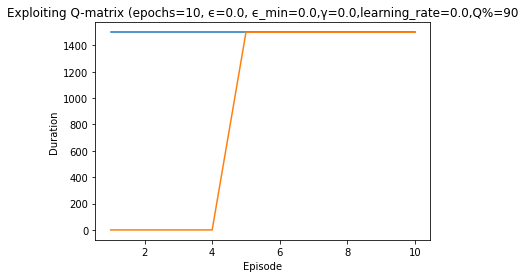

In [17]:
# Evaluate an agent that exploits the Q-table learnt above
tabularq_exploit_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=tqa.QTabularLearner(
        ep,
        trained=tabularq_run['learner'],
        gamma=0.0,
        learning_rate=0.0,
        exploit_percentile=90),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,
    render=False,
    verbosity=Verbosity.Quiet,
    title="Exploiting Q-matrix"
)

In [19]:
# Evaluate the Deep Q-learning agent
dql_run = learner.epsilon_greedy_search(
    cyberbattle_gym_env=gym_env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="DQL"
)

###### DQL
Learning with: episode_count=20,iteration_count=1500,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
  ## Episode: 1/20 'DQL' ϵ=0.9000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 1|Iteration 1500|reward:  272.0|last_reward_at:  753|Elapsed Time: 0:00:23||


  Episode 1 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/103 (0.02)
    explore-remote: 8/559 (0.01)
    explore-connect: 2/557 (0.00)
    exploit-local: 0/1 (0.00)
    exploit-remote: 0/168 (0.00)
    exploit-connect: 1/99 (0.01)
  exploit deflected to exploration: 23
  ## Episode: 2/20 'DQL' ϵ=0.6928, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 2|Iteration 1180|reward: 5381.0|last_reward_at: 1180|Elapsed Time: 0:00:24||


  Episode 2 ended at t=1180 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/74 (0.03)
    explore-remote: 5/377 (0.01)
    explore-connect: 1/344 (0.00)
    exploit-local: 1/42 (0.02)
    exploit-remote: 3/240 (0.01)
    exploit-connect: 4/87 (0.04)
  exploit deflected to exploration: 17
  ## Episode: 3/20 'DQL' ϵ=0.5682, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 3|Iteration 595|reward: 5381.0|last_reward_at:  595|Elapsed Time: 0:00:14||


  Episode 3 ended at t=595 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/34 (0.06)
    explore-remote: 4/172 (0.02)
    explore-connect: 1/148 (0.01)
    exploit-local: 1/12 (0.08)
    exploit-remote: 4/178 (0.02)
    exploit-connect: 4/35 (0.10)
  exploit deflected to exploration: 60
  ## Episode: 4/20 'DQL' ϵ=0.5156, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 4|Iteration 514|reward: 5381.0|last_reward_at:  514|Elapsed Time: 0:00:13||


  Episode 4 ended at t=514 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/26 (0.07)
    explore-remote: 5/136 (0.04)
    explore-connect: 0/139 (0.00)
    exploit-local: 1/15 (0.06)
    exploit-remote: 3/141 (0.02)
    exploit-connect: 5/41 (0.11)
  exploit deflected to exploration: 54
  ## Episode: 5/20 'DQL' ϵ=0.4750, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 5|Iteration 327|reward: 5375.0|last_reward_at:  327|Elapsed Time: 0:00:09||


  Episode 5 ended at t=327 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/16 (0.06)
    explore-remote: 4/89 (0.04)
    explore-connect: 0/77 (0.00)
    exploit-local: 2/23 (0.08)
    exploit-remote: 3/100 (0.03)
    exploit-connect: 5/7 (0.42)
  exploit deflected to exploration: 33
  ## Episode: 6/20 'DQL' ϵ=0.4513, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 6|Iteration 470|reward: 5381.0|last_reward_at:  470|Elapsed Time: 0:00:12||


  Episode 6 ended at t=470 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/18 (0.00)
    explore-remote: 4/120 (0.03)
    explore-connect: 1/99 (0.01)
    exploit-local: 3/11 (0.21)
    exploit-remote: 4/173 (0.02)
    exploit-connect: 4/33 (0.11)
  exploit deflected to exploration: 52
  ## Episode: 7/20 'DQL' ϵ=0.4198, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 7|Iteration 443|reward: 5375.0|last_reward_at:  443|Elapsed Time: 0:00:11||


  Episode 7 ended at t=443 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/15 (0.17)
    explore-remote: 1/105 (0.01)
    explore-connect: 0/86 (0.00)
    exploit-local: 0/10 (0.00)
    exploit-remote: 6/169 (0.03)
    exploit-connect: 5/43 (0.10)
  exploit deflected to exploration: 23
  ## Episode: 8/20 'DQL' ϵ=0.3927, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 8|Iteration 338|reward: 5375.0|last_reward_at:  338|Elapsed Time: 0:00:09||


  Episode 8 ended at t=338 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/12 (0.14)
    explore-remote: 2/69 (0.03)
    explore-connect: 0/76 (0.00)
    exploit-local: 1/7 (0.12)
    exploit-remote: 5/117 (0.04)
    exploit-connect: 5/42 (0.11)
  exploit deflected to exploration: 26
  ## Episode: 9/20 'DQL' ϵ=0.3735, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 9|Iteration 388|reward: 5381.0|last_reward_at:  388|Elapsed Time: 0:00:14||


  Episode 9 ended at t=388 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/14 (0.07)
    explore-remote: 6/109 (0.05)
    explore-connect: 0/90 (0.00)
    exploit-local: 2/4 (0.33)
    exploit-remote: 2/153 (0.01)
    exploit-connect: 5/2 (0.71)
  exploit deflected to exploration: 72
  ## Episode: 10/20 'DQL' ϵ=0.3531, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 10|Iteration 290|reward: 5381.0|last_reward_at:  290|Elapsed Time: 0:00:09||


  Episode 10 ended at t=290 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/13 (0.07)
    explore-remote: 2/41 (0.05)
    explore-connect: 0/62 (0.00)
    exploit-local: 2/3 (0.40)
    exploit-remote: 6/126 (0.05)
    exploit-connect: 5/29 (0.15)
  exploit deflected to exploration: 19
  ## Episode: 11/20 'DQL' ϵ=0.3388, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 11|Iteration 138|reward: 5369.0|last_reward_at:  138|Elapsed Time: 0:00:04||


  Episode 11 ended at t=138 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/7 (0.12)
    explore-remote: 2/28 (0.07)
    explore-connect: 0/21 (0.00)
    exploit-local: 2/3 (0.40)
    exploit-remote: 4/56 (0.07)
    exploit-connect: 5/9 (0.36)
  exploit deflected to exploration: 13
  ## Episode: 12/20 'DQL' ϵ=0.3323, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 12|Iteration 396|reward: 5381.0|last_reward_at:  396|Elapsed Time: 0:00:14||


  Episode 12 ended at t=396 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/27 (0.00)
    explore-remote: 3/92 (0.03)
    explore-connect: 0/61 (0.00)
    exploit-local: 3/4 (0.43)
    exploit-remote: 5/142 (0.03)
    exploit-connect: 5/54 (0.08)
  exploit deflected to exploration: 34
  ## Episode: 13/20 'DQL' ϵ=0.3147, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 13|Iteration 357|reward: 5381.0|last_reward_at:  357|Elapsed Time: 0:00:12||


  Episode 13 ended at t=357 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/18 (0.10)
    explore-remote: 1/83 (0.01)
    explore-connect: 0/59 (0.00)
    exploit-local: 1/12 (0.08)
    exploit-remote: 7/150 (0.04)
    exploit-connect: 5/19 (0.21)
  exploit deflected to exploration: 55
  ## Episode: 14/20 'DQL' ϵ=0.2999, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 14|Iteration 222|reward: 5375.0|last_reward_at:  222|Elapsed Time: 0:00:07||


  Episode 14 ended at t=222 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 5/33 (0.13)
    explore-connect: 1/29 (0.03)
    exploit-local: 3/8 (0.27)
    exploit-remote: 2/93 (0.02)
    exploit-connect: 4/32 (0.11)
  exploit deflected to exploration: 14
  ## Episode: 15/20 'DQL' ϵ=0.2912, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 15|Iteration 288|reward: 5375.0|last_reward_at:  288|Elapsed Time: 0:00:09||


  Episode 15 ended at t=288 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/15 (0.12)
    explore-remote: 4/55 (0.07)
    explore-connect: 0/51 (0.00)
    exploit-local: 1/12 (0.08)
    exploit-remote: 3/109 (0.03)
    exploit-connect: 5/31 (0.14)
  exploit deflected to exploration: 42
  ## Episode: 16/20 'DQL' ϵ=0.2805, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 16|Iteration 507|reward: 5381.0|last_reward_at:  507|Elapsed Time: 0:00:21||


  Episode 16 ended at t=507 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/22 (0.00)
    explore-remote: 4/100 (0.04)
    explore-connect: 0/61 (0.00)
    exploit-local: 3/10 (0.23)
    exploit-remote: 4/232 (0.02)
    exploit-connect: 5/66 (0.07)
  exploit deflected to exploration: 70
  ## Episode: 17/20 'DQL' ϵ=0.2631, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 17|Iteration 293|reward: 5381.0|last_reward_at:  293|Elapsed Time: 0:00:12||


  Episode 17 ended at t=293 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/9 (0.18)
    explore-remote: 4/58 (0.06)
    explore-connect: 0/45 (0.00)
    exploit-local: 1/3 (0.25)
    exploit-remote: 4/127 (0.03)
    exploit-connect: 5/35 (0.12)
  exploit deflected to exploration: 50
  ## Episode: 18/20 'DQL' ϵ=0.2538, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 18|Iteration 217|reward: 5375.0|last_reward_at:  217|Elapsed Time: 0:00:06||


  Episode 18 ended at t=217 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/7 (0.00)
    explore-remote: 6/34 (0.15)
    explore-connect: 0/30 (0.00)
    exploit-local: 3/0 (1.00)
    exploit-remote: 1/116 (0.01)
    exploit-connect: 5/15 (0.25)
  exploit deflected to exploration: 25
  ## Episode: 19/20 'DQL' ϵ=0.2473, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 19|Iteration 229|reward: 5375.0|last_reward_at:  229|Elapsed Time: 0:00:08||


  Episode 19 ended at t=229 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/14 (0.00)
    explore-remote: 3/40 (0.07)
    explore-connect: 0/28 (0.00)
    exploit-local: 3/11 (0.21)
    exploit-remote: 4/115 (0.03)
    exploit-connect: 5/6 (0.45)
  exploit deflected to exploration: 39
  ## Episode: 20/20 'DQL' ϵ=0.2407, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 20|Iteration 284|reward: 5375.0|last_reward_at:  284|Elapsed Time: 0:00:11||


  Episode 20 ended at t=284 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/12 (0.00)
    explore-remote: 2/49 (0.04)
    explore-connect: 1/42 (0.02)
    exploit-local: 3/16 (0.16)
    exploit-remote: 5/126 (0.04)
    exploit-connect: 4/24 (0.14)
  exploit deflected to exploration: 37
simulation ended


In [20]:
# Evaluate an agent that exploits the Q-function learnt above
dql_exploit_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=dql_run['learner'],
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=0.0,
    epsilon_minimum=0.00,
    render=False,
    plot_episodes_length=False,
    verbosity=Verbosity.Quiet,
    title="Exploiting DQL"
)

###### Exploiting DQL
Learning with: episode_count=10,iteration_count=1500,ϵ=0.0,ϵ_min=0.0, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
  ## Episode: 1/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 1|Iteration 324|reward: 5369.0|last_reward_at:  324|Elapsed Time: 0:00:16||


  Episode 1 ended at t=324 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/7 (0.22)
    explore-remote: 0/23 (0.00)
    explore-connect: 0/22 (0.00)
    exploit-local: 1/30 (0.03)
    exploit-remote: 6/217 (0.03)
    exploit-connect: 5/11 (0.31)
  exploit deflected to exploration: 54
  ## Episode: 2/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 2|Iteration 170|reward: 5375.0|last_reward_at:  170|Elapsed Time: 0:00:06||


  Episode 2 ended at t=170 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 1/3 (0.25)
    explore-connect: 0/7 (0.00)
    exploit-local: 2/9 (0.18)
    exploit-remote: 6/102 (0.06)
    exploit-connect: 5/29 (0.15)
  exploit deflected to exploration: 17
  ## Episode: 3/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 3|Iteration 213|reward: 5369.0|last_reward_at:  213|Elapsed Time: 0:00:07||


  Episode 3 ended at t=213 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/4 (0.00)
    explore-remote: 0/14 (0.00)
    explore-connect: 0/13 (0.00)
    exploit-local: 3/9 (0.25)
    exploit-remote: 6/130 (0.04)
    exploit-connect: 5/29 (0.15)
  exploit deflected to exploration: 31
  ## Episode: 4/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 4|Iteration 198|reward: 5369.0|last_reward_at:  198|Elapsed Time: 0:00:06||


  Episode 4 ended at t=198 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/2 (0.00)
    explore-remote: 1/10 (0.09)
    explore-connect: 0/4 (0.00)
    exploit-local: 3/4 (0.43)
    exploit-remote: 5/115 (0.04)
    exploit-connect: 5/49 (0.09)
  exploit deflected to exploration: 17
  ## Episode: 5/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 5|Iteration 567|reward: 5369.0|last_reward_at:  567|Elapsed Time: 0:00:19||


  Episode 5 ended at t=567 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/8 (0.00)
    explore-remote: 2/29 (0.06)
    explore-connect: 0/23 (0.00)
    exploit-local: 3/12 (0.20)
    exploit-remote: 4/357 (0.01)
    exploit-connect: 5/124 (0.04)
  exploit deflected to exploration: 62
  ## Episode: 6/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 6|Iteration 171|reward: 5369.0|last_reward_at:  171|Elapsed Time: 0:00:06||


  Episode 6 ended at t=171 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 1/7 (0.12)
    explore-connect: 0/12 (0.00)
    exploit-local: 3/14 (0.18)
    exploit-remote: 5/94 (0.05)
    exploit-connect: 5/25 (0.17)
  exploit deflected to exploration: 25
  ## Episode: 7/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 7|Iteration 110|reward: 5369.0|last_reward_at:  110|Elapsed Time: 0:00:03||


  Episode 7 ended at t=110 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/1 (0.00)
    explore-remote: 0/9 (0.00)
    explore-connect: 0/1 (0.00)
    exploit-local: 3/8 (0.27)
    exploit-remote: 6/65 (0.08)
    exploit-connect: 5/12 (0.29)
  exploit deflected to exploration: 11
  ## Episode: 8/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 8|Iteration 141|reward: 5369.0|last_reward_at:  141|Elapsed Time: 0:00:05||


  Episode 8 ended at t=141 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/5 (0.17)
    explore-remote: 1/19 (0.05)
    explore-connect: 0/5 (0.00)
    exploit-local: 2/3 (0.40)
    exploit-remote: 5/84 (0.06)
    exploit-connect: 5/11 (0.31)
  exploit deflected to exploration: 31
  ## Episode: 9/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 9|Iteration 193|reward: 5375.0|last_reward_at:  193|Elapsed Time: 0:00:07||


  Episode 9 ended at t=193 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/3 (0.00)
    explore-remote: 1/12 (0.08)
    explore-connect: 0/8 (0.00)
    exploit-local: 3/10 (0.23)
    exploit-remote: 6/111 (0.05)
    exploit-connect: 5/34 (0.13)
  exploit deflected to exploration: 24
  ## Episode: 10/10 'Exploiting DQL' ϵ=0.0000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10


Episode 10|Iteration 170|reward: 5375.0|last_reward_at:  170|Elapsed Time: 0:00:06||


  Episode 10 ended at t=170 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/5 (0.00)
    explore-remote: 0/14 (0.00)
    explore-connect: 0/11 (0.00)
    exploit-local: 3/2 (0.60)
    exploit-remote: 7/105 (0.06)
    exploit-connect: 5/18 (0.22)
  exploit deflected to exploration: 30
simulation ended


In [18]:
# Evaluate the random agent
random_run = learner.epsilon_greedy_search(
    gym_env,
    ep,
    learner=learner.RandomPolicy(),
    episode_count=eval_episode_count,
    iteration_count=iteration_count,
    epsilon=1.0,  # purely random
    render=False,
    verbosity=Verbosity.Quiet,
    plot_episodes_length=False,
    title="Random search"
)

###### Random search
Learning with: episode_count=10,iteration_count=1500,ϵ=1.0,ϵ_min=0.0, 
  ## Episode: 1/10 'Random search' ϵ=1.0000, 


Episode 1|Iteration 1051|reward: 5381.0|last_reward_at: 1051|Elapsed Time: 0:00:01||


  Episode 1 ended at t=1051 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/119 (0.02)
    explore-remote: 8/470 (0.02)
    explore-connect: 5/446 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 2/10 'Random search' ϵ=1.0000, 


Episode 2|Iteration 1378|reward: 5381.0|last_reward_at: 1378|Elapsed Time: 0:00:01||


  Episode 2 ended at t=1378 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/138 (0.02)
    explore-remote: 8/627 (0.01)
    explore-connect: 5/597 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 3/10 'Random search' ϵ=1.0000, 


Episode 3|Iteration 1500|reward:  272.0|last_reward_at: 1234|Elapsed Time: 0:00:01||


  Episode 3 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/188 (0.01)
    explore-remote: 8/679 (0.01)
    explore-connect: 3/620 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 4/10 'Random search' ϵ=1.0000, 


Episode 4|Iteration 1500|reward:  381.0|last_reward_at: 1434|Elapsed Time: 0:00:01||


  Episode 4 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/200 (0.01)
    explore-remote: 8/713 (0.01)
    explore-connect: 4/572 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 5/10 'Random search' ϵ=1.0000, 


Episode 5|Iteration 572|reward: 5381.0|last_reward_at:  572|Elapsed Time: 0:00:00||


  Episode 5 ended at t=572 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/64 (0.04)
    explore-remote: 8/265 (0.03)
    explore-connect: 5/227 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 6/10 'Random search' ϵ=1.0000, 


Episode 6|Iteration 1500|reward:  272.0|last_reward_at:  751|Elapsed Time: 0:00:01||


  Episode 6 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/154 (0.01)
    explore-remote: 8/703 (0.01)
    explore-connect: 3/630 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 7/10 'Random search' ϵ=1.0000, 


Episode 7|Iteration 1500|reward:  381.0|last_reward_at:  427|Elapsed Time: 0:00:01||


  Episode 7 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/138 (0.02)
    explore-remote: 8/697 (0.01)
    explore-connect: 4/650 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 8/10 'Random search' ϵ=1.0000, 


Episode 8|Iteration 1500|reward:  272.0|last_reward_at:  849|Elapsed Time: 0:00:01||


  Episode 8 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/181 (0.01)
    explore-remote: 8/715 (0.01)
    explore-connect: 3/591 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 9/10 'Random search' ϵ=1.0000, 


Episode 9|Iteration 1006|reward: 5381.0|last_reward_at: 1006|Elapsed Time: 0:00:01||


  Episode 9 ended at t=1006 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/108 (0.03)
    explore-remote: 8/424 (0.02)
    explore-connect: 5/458 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 10/10 'Random search' ϵ=1.0000, 


Episode 10|Iteration 1500|reward:  331.0|last_reward_at:  449|Elapsed Time: 0:00:02||


  Episode 10 stopped at t=1500 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/175 (0.02)
    explore-remote: 8/643 (0.01)
    explore-connect: 3/668 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
simulation ended


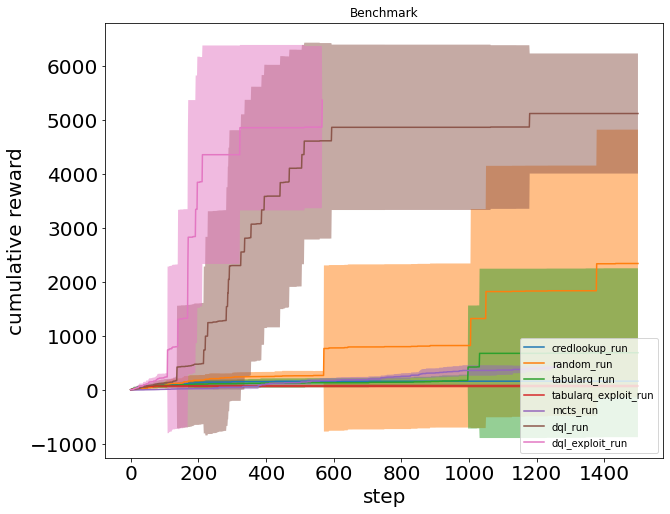

In [21]:
new_plot('Benchmark')
all_runs = [
    (credlookup_run['all_episodes_rewards'], 'credlookup_run'), 
    (random_run['all_episodes_rewards'], 'random_run'), 
    (tabularq_run['all_episodes_rewards'], 'tabularq_run'), 
    (tabularq_exploit_run['all_episodes_rewards'], 'tabularq_exploit_run'),
    (trimmed_rewards, 'mcts_run'),
    (dql_run['all_episodes_rewards'], 'dql_run'),
    (dql_exploit_run['all_episodes_rewards'], 'dql_exploit_run')
]
for r, r_title in all_runs:
    plot_episodes_rewards_averaged(r, r_title)
plt.legend(loc="lower right")
plt.show()

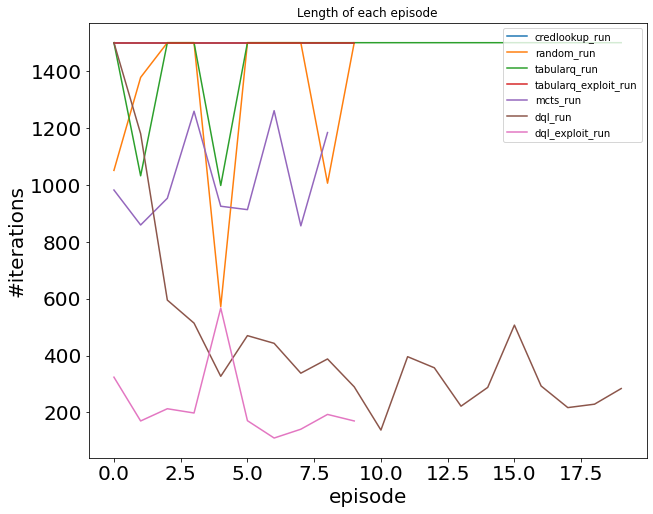

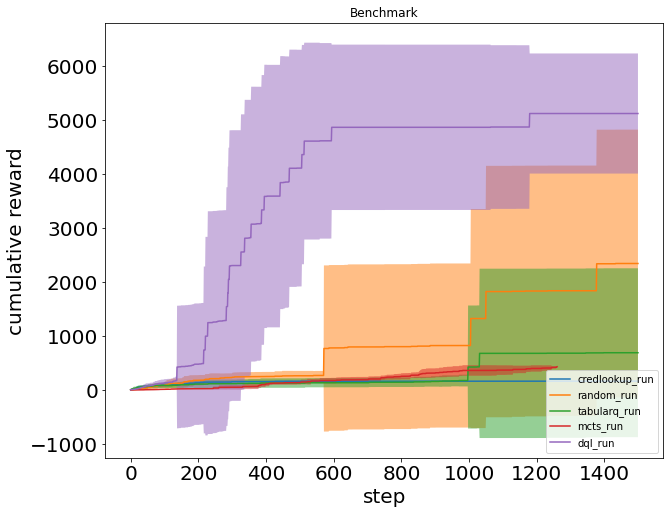

In [22]:
# new_plot('Benchmark')
all_runs = [
    {'all_episodes_rewards': credlookup_run['all_episodes_rewards'], 'title':'credlookup_run'}, 
    {'all_episodes_rewards': random_run['all_episodes_rewards'], 'title':'random_run'}, 
    {'all_episodes_rewards': tabularq_run['all_episodes_rewards'], 'title':'tabularq_run'}, 
    {'all_episodes_rewards': tabularq_exploit_run['all_episodes_rewards'], 'title':'tabularq_exploit_run'},
    {'all_episodes_rewards': trimmed_rewards, 'title':'mcts_run'},
    {'all_episodes_rewards': dql_run['all_episodes_rewards'], 'title':'dql_run'},
    {'all_episodes_rewards': dql_exploit_run['all_episodes_rewards'], 'title':'dql_exploit_run'}
]

plot_episodes_length(all_runs, 'Bench')
plt.show()


new_plot('Benchmark')
all_runs = [
    (credlookup_run['all_episodes_rewards'], 'credlookup_run'), 
    (random_run['all_episodes_rewards'], 'random_run'), 
    (tabularq_run['all_episodes_rewards'], 'tabularq_run'), 
    (trimmed_rewards, 'mcts_run'),
    (dql_run['all_episodes_rewards'], 'dql_run'),
]
for r, r_title in all_runs:
    plot_episodes_rewards_averaged(r, r_title)
plt.legend(loc="lower right")
plt.show()

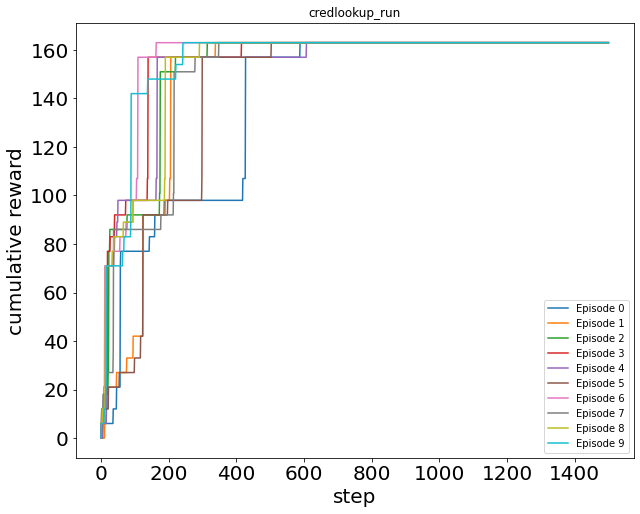

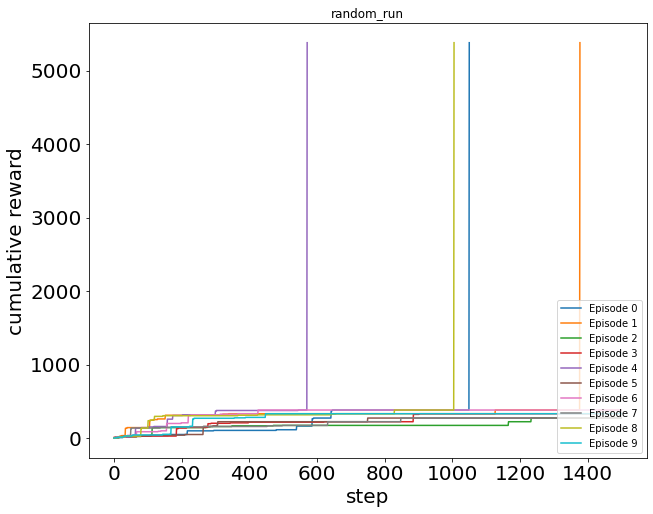

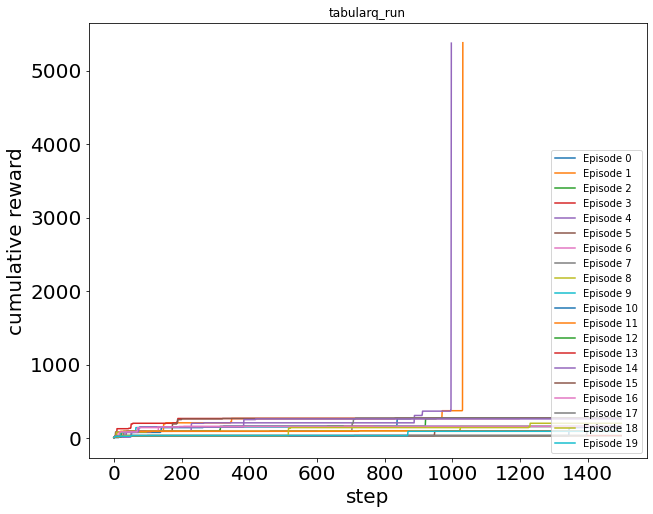

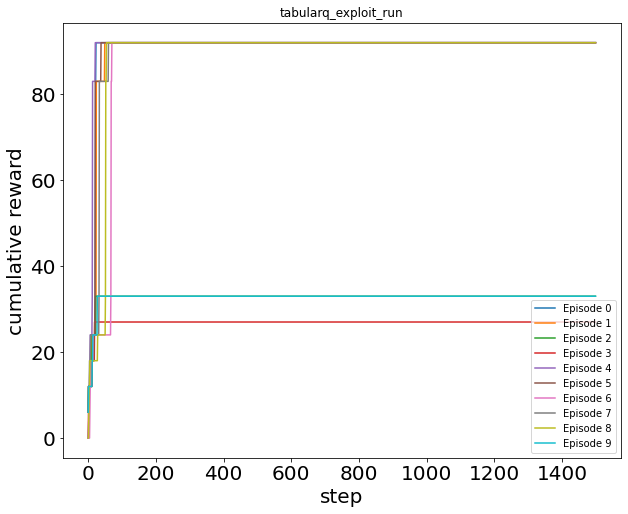

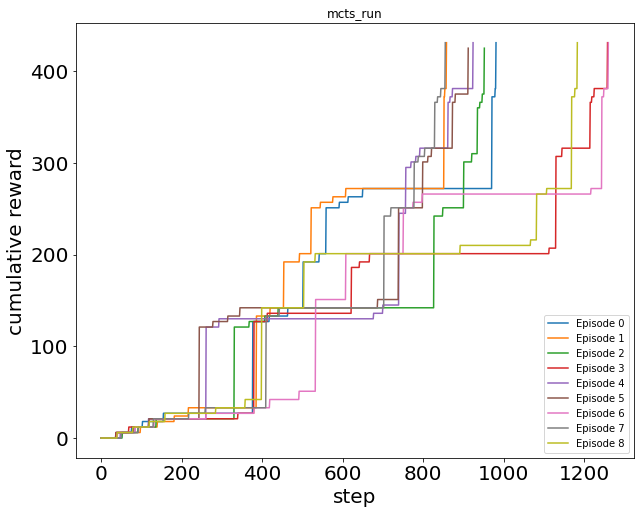

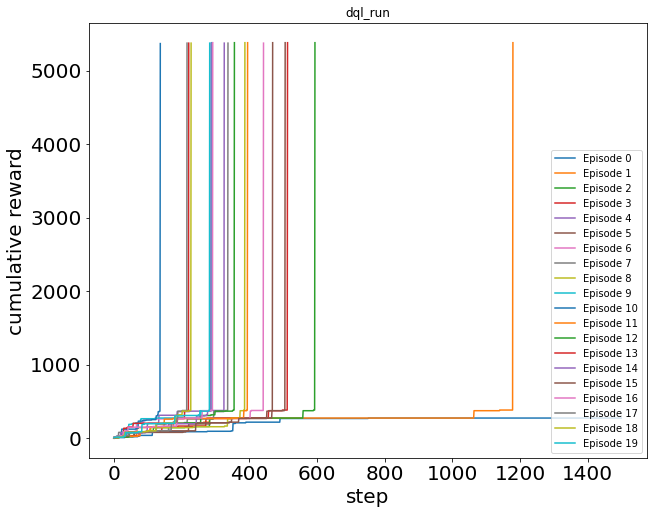

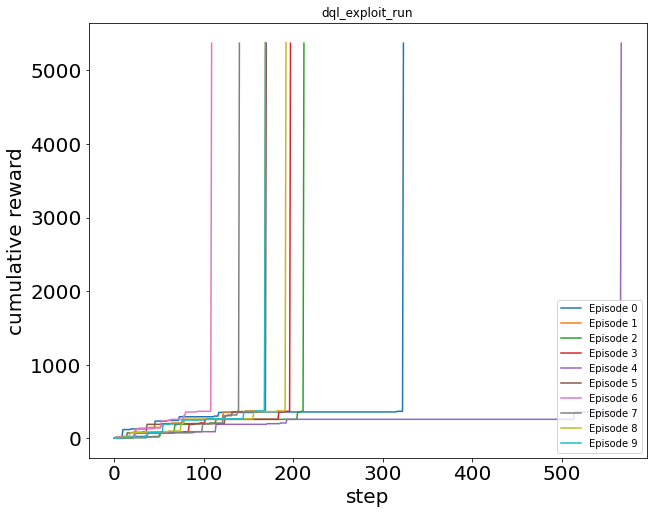

In [23]:
all_runs = [
    {'all_episodes_rewards': credlookup_run['all_episodes_rewards'], 'title':'credlookup_run'}, 
    {'all_episodes_rewards': random_run['all_episodes_rewards'], 'title':'random_run'}, 
    {'all_episodes_rewards': tabularq_run['all_episodes_rewards'], 'title':'tabularq_run'}, 
    {'all_episodes_rewards': tabularq_exploit_run['all_episodes_rewards'], 'title':'tabularq_exploit_run'},
    {'all_episodes_rewards': trimmed_rewards, 'title':'mcts_run'},
    {'all_episodes_rewards': dql_run['all_episodes_rewards'], 'title':'dql_run'},
    {'all_episodes_rewards': dql_exploit_run['all_episodes_rewards'], 'title':'dql_exploit_run'}
]
for r in all_runs:
    plot_all_episodes(r)
plt.show()